# Simulating DESI Spectra

The goal of this notebook is to demonstrate how to generate some simple DESI spectra using the *quickgen* utility.

For additional (albeit somewhat outdated) information and documentation about *quickgen* see  
https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=1429

If you identify any errors or have requests for additional functionality please create a new issue on  
https://github.com/desihub/desisim/issues
or send a note to <desi-data@desi.lbl.gov>.

## Getting started.

First, import all the package dependencies.

In [25]:
import os
import numpy as np

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
import desispec.io
import desisim.io
from desisim.obs import new_exposure
from desisim.scripts import quickgen

from desiutil.log import get_logger
log = get_logger()

Make sure we have all the right environment variables set (assuming the bash shell).  If any of these environment variables are missing please set them in your *.bashrc* file (and then restart this notebook) or create them for just this notebook session using the *%env* magic command, as we demonstrate below.

In [30]:
def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 
            'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

In [31]:
check_env()

DESIMODEL environment set to /Users/ioannis/repos/desihub/desimodel
DESI_ROOT environment set to /Users/ioannis/research/projects/desi
DESI_SPECTRO_SIM environment set to /Users/ioannis/research/projects/desi/spectro/sim
DESI_SPECTRO_DATA environment set to /Users/ioannis/research/projects/desi/spectro/data
DESI_SPECTRO_REDUX environment set to /Users/ioannis/research/projects/desi/spectro/redux
SPECPROD environment set to example
PIXPROD environment set to example


Let's reassign the *SPECPROD* and *PIXPROD* environments to something other than "dailytest" so that we don't conflict with the outputs of the standard DESI integration test.

In [6]:
%env SPECPROD=example
%env PIXPROD=example

env: SPECPROD=example
env: PIXPROD=example


## Specify the parameters of the simulation.

Next, specify the number and spectral type distribution of spectra we want to simulate, and the random seed.  Setting the seed here (which can be any number at all!) ensures that your simulations are reproducible.  Let's also explicitly set the *night* of the "observations" (the default is to use the current date) and the *expid* or exposure ID number (which would allow you to simulate more than one DESI exposure).

The *flavor* option is used to choose the correct sky-brightness model and it also determines the distribution of targets for a given flavor.  For example, *flavor='dark'* returns the right relative sampling density of ELGs, LRGs, and QSOs.  The other available (science target) options for *flavor* are 'dark', 'gray', 'grey', 'bright', 'bgs', 'mws', 'lrg', 'elg', 'qso', and 'std'.  (You can also set flavor to either 'arc' or 'flat' but that would be boring!)

In [48]:
nspec = 50
seed = 555
flavor = 'dark'
night = '20170615'
expid = 0

In [99]:
simdir = desisim.io.simdir(night=night)
print(simdir)

/Users/ioannis/research/projects/desi/spectro/sim/example/20170615


## Generate the fibermap and truth tables.

The first step is to generate the *fibermap* and *simspec* files needed by *quickgen*.  The *fibermap* table contains (simulated) information about the position of each target in the DESI focal plane, while the *simspec* table holds the "truth" spectra and the intrinsic properties of each object (redshift, noiseless photometry, [OII] flux, etc.).

Note that the *tileid* and *exptime* (exposure time) optional inputs are shown here for demonstration purposes but do not need to be explicitly set.  In particular, the default exposure time is based on the value specified in the *$DESIMODEL/data/desi.yaml* parameter file.

The *fibermap* object is an astropy Table with lots of goodies while the *truth* object is a dictionary that we won't use anymore (we'll instead use the *simspec* table; see below).  The fibermap data model is described at  
http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_DATA/NIGHT/fibermap-EXPID.html

In [8]:
fibermap, truth = new_exposure(flavor=flavor, nspec=nspec, seed=seed, night=night, 
                               expid=expid, tileid=None, exptime=None)

INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/elg_templates_v2.0.fits
INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/elg_templates_v2.0.fits
INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.

Finally, even though we have the *fibermap* table in hand, the code below demonstrates how it and the *simspec* table can be read from on-disk.  The *simspec* data model is described at  
http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_SIM/PIXPROD/NIGHT/simspec-EXPID.html
In particular, HDU=13 contains an extensive (and useful!) metadata table.

In [107]:
fiberfile = desispec.io.meta.findfile('fibermap', night=night, expid=expid, outdir=simdir)
simspecfile = desisim.io.findfile('simspec', night=night, expid=expid, outdir=simdir)

In [108]:
log.info('Reading fibermap file {}'.format(fiberfile))
hdu = fits.open(fiberfile)
hdu.info()
fibermap = Table(hdu[1].data)
hdu.close()

INFO:<ipython-input-108-59b7db187c0a>:1:<module>: Reading fibermap file /Users/ioannis/research/projects/desi/spectro/sim/example/20170615/fibermap-00000000.fits
Filename: /Users/ioannis/research/projects/desi/spectro/sim/example/20170615/fibermap-00000000.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       6   ()      
  1  FIBERMAP    BinTableHDU     98   50R x 26C   [10A, 20A, 8A, K, K, K, K, 5E, 50A, J, K, J, J, J, J, E, D, D, D, D, D, D, D, D, E, E]   


In [109]:
fibermap[3]

OBJTYPE,TARGETCAT,BRICKNAME,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,MAG [5],FILTER [5],SPECTROID,POSITIONER,LOCATION,DEVICE_LOC,PETAL_LOC,FIBER,LAMBDAREF,RA_TARGET,DEC_TARGET,RA_OBS,DEC_OBS,X_TARGET,Y_TARGET,X_FVCOBS,Y_FVCOBS,Y_FVCERR,X_FVCERR
str10,str20,str8,int64,int64,int64,int64,float32,str10,int32,int64,int32,int32,int32,int32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32
ELG,,3350p205,3561499325993422263,2,0,0,23.2547 .. 22.5634,DECAM_G .. WISE_W2,0,82,82,82,0,3,5400.0,335.167583443,20.5840708185,335.167583443,20.5840708185,-31.5795923296,-172.635369698,-31.5795923296,-172.635369698,0.0,0.0


In [110]:
log.info('Reading simspec file {}.'.format(simspecfile))
hdu = fits.open(simspecfile)
hdu.info()
meta = Table(hdu[13].data)
hdu.close()

INFO:<ipython-input-110-079a1c11142f>:1:<module>: Reading simspec file /Users/ioannis/research/projects/desi/spectro/sim/example/20170615/simspec-00000000.fits.
Filename: /Users/ioannis/research/projects/desi/spectro/sim/example/20170615/simspec-00000000.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      15   ()      
  1  WAVE        ImageHDU         9   (31901,)   float64   
  2  FLUX        ImageHDU         9   (31901, 50)   float32   
  3  SKYFLUX     ImageHDU         8   (31901,)   float32   
  4  WAVE_B      ImageHDU         9   (12326,)   float64   
  5  PHOT_B      ImageHDU         8   (12326, 50)   float32   
  6  SKYPHOT_B   ImageHDU         7   (12326,)   float32   
  7  WAVE_R      ImageHDU         9   (11205,)   float64   
  8  PHOT_R      ImageHDU         8   (11205, 50)   float32   
  9  SKYPHOT_R   ImageHDU         7   (11205,)   float32   
 10  WAVE_Z      ImageHDU         9   (12765,)   float64   
 11  PHOT_Z      ImageHDU 

In [111]:
meta[:3]

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,DECAM_FLUX [6],WISE_FLUX [2],OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
SKY,,-1,-1,0.0,-1.0,0.0 .. 0.0,0.0 .. 0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ELG,,6752,3244113739,1.53694,23.2023,0.233109 .. 1.47868,4.03679 .. 4.40491,5.45512e-17,-1.0,50.9816,-1.0,1.09257,49.0409,0.733237,-0.0850786,0.275525,-0.248196,-0.19466,-1.0,-1.0,-1.0,-1.0,-1.0
LRG,,18,3244113739,0.877407,20.256,0.114243 .. 9.0901,29.0752 .. 20.158,-1.0,-1.0,-1.0,-1.0,1.50574,183.679,-1.0,-1.0,-1.0,-1.0,-1.0,0.0096,2.81838,-1.0,-1.0,-1.0


Here's a fun simple plot of the redshift histogram distributions.  Now you try!

(-0.2, 1.7113039016723635)

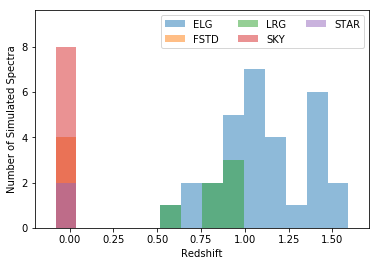

In [86]:
allobjtype = meta['OBJTYPE']
redlim = (-0.2, 1.1*meta['REDSHIFT'].max())
fig, ax = plt.subplots()
for objtype in sorted(set(allobjtype)):
    indx = objtype == allobjtype
    hh = ax.hist(meta['REDSHIFT'][indx], bins=nspec//3, 
                 label=objtype, alpha=0.5, range=redlim)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Simulated Spectra')
ax.legend(loc='upper right', ncol=3)
ax.margins(0.2)
ax.set_xlim(redlim)

## Simulating spectra using quickgen.

We're now ready to simulate DESI spectra using *quickgen*.  Since we're calling *quickgen* from within the notebook (rather than from the command line in a terminal) we have to parse the *simspec* and *fibermap* inputs first.

In [113]:
args = quickgen.parse([
    '--simspec', simspecfile,
    '--fibermap', fiberfile
])
print(args)
#quickgen.main(args)    

Namespace(add_SNeIa=False, airmass=1.25, brickname=None, config='desi', exptime=None, fibermap='/Users/ioannis/research/projects/desi/spectro/data/20170615/fibermap-00000000.fits', frameonly=False, moon_angle=None, moon_phase=None, moon_zenith=None, nspec=100, nstart=0, objtype=None, outdir='.', outdir_truth=None, rmagrange_bgs=(15.0, 19.5), seed=0, simspec='/Users/ioannis/research/projects/desi/spectro/sim/example/20170615/simspec-00000000.fits', sne_rfluxratiorange=(0.1, 1.0), spectrograph=None, verbose=False, zrange_bgs=(0.01, 0.4), zrange_elg=(0.6, 1.6), zrange_lrg=(0.5, 1.1), zrange_qso=(0.5, 4.0))


In [ ]:
# Generate fibermap and simspec files.
lensdir = priors['LENSDIR']
for ii in range(nexp):
    fibermap, truth = new_lensing_exposure(priors, exptime=priors['EXPTIME'][ii], night=priors['NIGHT'],
                                           tileid=priors['TILEID'], expid=priors['EXPID'][ii], seed=seed, 
                                           outdir=lensdir)
    # Write out truth table of the source.
    metafile = os.path.join(lensdir, priors['NIGHT'], 'meta-source-{:08d}.fits'.format(priors['EXPID'][ii]))
    truth['META_SOURCE'].write(metafile, overwrite=True)
    
    metafile = os.path.join(lensdir, priors['NIGHT'], 'meta-lens-{:08d}.fits'.format(priors['EXPID'][ii]))
    truth['META'].write(metafile, overwrite=True)

In [ ]:
# Run quickgen
lensdir = priors['LENSDIR']
night = priors['NIGHT']
for ii in range(nexp):
    expid = priors['EXPID'][ii]
    quickgen.main(quickgen.parse([
        '--simspec', os.path.join(lensdir, night, 'simspec-{:08d}.fits'.format(expid)), 
        '--fibermap', os.path.join(lensdir, night, 'fibermap-{:08d}.fits'.format(expid))
    ]))


In [ ]:
# Make bricks from cframe files.
from desispec.scripts import makebricks
makebricks.main(makebricks.parse(['--night', priors['NIGHT'], '--verbose']))

In [ ]:
from glob import glob

# Get the list of bricks
bricks = glob(os.path.join(lensdir, 'bricks', '*'))
print(bricks)


In [ ]:
# Figure out redshift fitting.
from desispec.scripts import zfind
from glob import glob

# Get the list of bricks
bricks = glob(os.path.join(lensdir, 'bricks', '*'))
print(bricks)

nproc = 4
zrange = [0.4, 0.6]

for bb in list(set(bricks)):
    print(bb)
    #brickfiles = [os.path.join(lensdir, 'bricks', bb, 'brick-{}-{}.fits'.format(ch, bb)) for ch in ['b', 'r', 'z']]
    #print(brickfiles)
    zargs = zfind.parse([
        '--brick', bb, 
        '--nproc', '{}'.format(nproc),
        '--zrange-galaxy', '{}'.format(zrange[0]), '{}'.format(zrange[1]), 
        #'--zspec', 
        #'--qafile', os.path.join(lensdir, 'bricks', bb, 'qa-zbest-{}.pdf'.format(bb)),
        #'--outfile', os.path.join(lensdir, 'zbest-{}.fits'.format(exp))
        '--objtype', 'LRG'])
    zfind.main(zargs)


In [ ]:
#set the brick name and take the zbest file for the specified brick
thisbrick = '3587m005'
zfile = os.path.join(lensdir, 'bricks', thisbrick, 'zbest-{}.fits'.format(thisbrick))
zbest = Table(fitsio.read(zfile, ext=1))
print(zbest)

#Create the table for the set brick 
simfile = os.path.join(lensdir, priors['NIGHT'], 'simspec-{:08d}.fits'.format(priors['EXPID'][0]))
sim1 = read_simspec(simfile)
print(Table(sim1.metadata))



In [ ]:
# Below here requires hacking....


In [ ]:
# Read the simspec file to get trueflux.
simfile = os.path.join(lensdir, 'simspec-{:08d}.fits'.format(0))
sim = read_simspec(simfile)

simfile1 = os.path.join(lensdir, 'simspec-{:08d}.fits'.format(1))
sim1 = read_simspec(simfile1)

In [ ]:
#ploting the lens for the three color cuts: blue, red, and near infrared 
for channel in ('b', 'r', 'z'):
    ff = desispec.io.read_frame(os.path.join(lensdir, 'cframe-{}0-{:08d}.fits'.format(channel, 0)))
    plt.plot(ff.wave, ff.flux[0, :])
    
    ff_test = desispec.io.read_frame(os.path.join(lensdir, 'cframe-{}0-{:08d}.fits'.format(channel, 1)))
    plt.plot(ff_test.wave, ff_test.flux[0, :])

plt.plot(sim.wave['brz'], sim.flux[0, :], color='k')
plt.ylim(-4, 10)    
plt.show()

for channel in ('b', 'r', 'z'):
    ff = desispec.io.read_frame(os.path.join(lensdir, 'cframe-{}0-{:08d}.fits'.format(channel, 0)))
    ff_test = desispec.io.read_frame(os.path.join(lensdir, 'cframe-{}0-{:08d}.fits'.format(channel, 1)))
    plt.plot(ff.wave, ff.flux[0, :] * np.sqrt(ff.ivar[0, :]))
    plt.plot(ff_test.wave, ff_test.flux[0, :] * np.sqrt(ff_test.ivar[0, :]))
plt.xlim(6000, 7000)
plt.ylim(0, 25)
plt.show()

